# Mapping to the CIPIC Interaural Polar Coordinates

CIPIC uses a special *interaural polar coordinate system* (IPCS) that needs to be addressed in order to make a 3D audio demo. Two other aspects to be consider are:

1. CIPIC assumes the sound source lies on a sphere of radius 1m, so due to sound wave divergence, the amplitude needs to be scaled inversely with radial distance (inverse-squared in the sound intensity sense).
2. To properly represent a sound source closer than 1m there is a parallax error that must be dealt with as explained in [Fitzpatrick].

The ultimate goal is to represent an audio source arriving from any set of coordinates, in this case $(x_1,y_1,z_1$). 

## Notebook Imports and Configuration

In [1]:
%pylab inline
%matplotlib widget
import scipy.signal as signal
import scipy.io as io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


### Figure Rendering Options

In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

### Cylindrical Coordinates for Sound Source
<img src="figures/3D_Coordinates.png" width="75%">
<!--- Image('figures/3D_Coordinates.png',width='90%')--->

## HRTF Calculation for a Spherical Head (Duda-Martens)
* Duda, R. and Martens, W. (1998), Range dependence of the response of a spherical head model, *J. Acoust. Soc. Am. 104 (5)*.

The algorithm coded below is found in the above paper as pseudo-code, with conjugation to match more conventional signal processing notation. 

In [9]:
def HRTF_sph(theta, f, r = 1.0, R = 0.0875, c = 344.4, 
           threshold = 1e-6):
    """
    HRTF calculation for a rigid sphere with source 
    r meters from the sphere center
    
    Coded from pseudo-code to Python by Mark Wickert
    
    Reference: Appendix A of J. Acoust. Soc. Am., 
    Vol. 104, No. 5, November 1998 R. O. Duda and 
    W. L. Martens: Range dependence of the response 
    of a spherical head model.
    """   
    x = cos(theta*pi/180)
    mu = (2 * pi * f * R)/c
    rho = r/R
    zr = 1/(1j * mu * rho)
    zR = 1/(1j * mu)
    Qr2 = zr
    Qr1 = zr * (1 - zr)
    QR2 = zR
    QR1 = zR * (1 - zR)
    P2 = 1
    P1 = x
    summ = 0
    term = zr/(zR * (zR - 1))
    summ += term
    term = (3 * x * zr * (zr - 1) )/ \
           (zR * (2 * zR * (zR - 1) + 1))
    summ += term;
    oldratio = 1
    newratio = abs(term)/abs(summ)
    m = 2
    while (oldratio > threshold) or \
          (newratio > threshold):
        Qr = -(2 * m - 1) * zr * Qr1 + Qr2
        QR = -(2 * m - 1) * zR * QR1 + QR2
        P = ((2 * m - 1) * x * \
             P1 - (m - 1) * P2)/m
        term = ((2 * m + 1) * P * Qr)/((m + 1) \
                * zR * QR - QR1)
        summ += term
        m += 1
        Qr2 = Qr1
        Qr1 = Qr
        QR2 = QR1
        QR1 = QR
        P2 = P1
        P1 = P
        oldratio = newratio
        newratio = abs(term)/abs(summ)
    # conjugate match traveling wave convention of exp[j*(w*t - k*r)]
    H = conj((rho * exp(-1j * mu) * summ)/(1j * mu))
    return H

### HRTF Calculation and Frequency Response Plotting
Plot a frequency response for a $120^\circ$ incidence angle. 

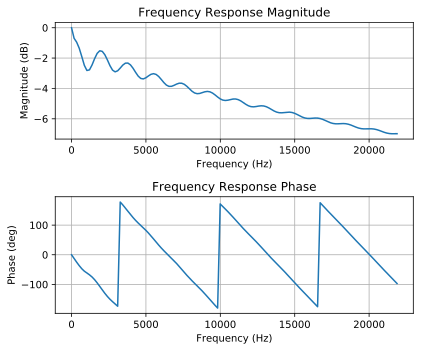

In [10]:
fs = 44100
Nfft = 2**8
theta_S = 120
r = 1.0 #1.25*0.0875
df = fs/Nfft
f = arange(df,fs/2,df)
HRTF = zeros(len(f),dtype=complex128)
for k, fk in enumerate(f):
    HRTF[k] = HRTF_sph(theta_S,fk,r=r,R = 0.0875)
# Set DC value to 1
HRTF = hstack(([1],HRTF))
f = hstack(([0],f))

figure(figsize=(6,5))
subplot(211)
plot(f,20*log10(abs(HRTF)))
title(r'Frequency Response Magnitude')
ylabel(r'Magnitude (dB)')
xlabel(r'Frequency (Hz)')
grid();

subplot(212)
plot(f,180/pi*angle(HRTF))
title(r'Frequency Response Phase')
ylabel(r'Phase (deg)')
xlabel(r'Frequency (Hz)')
grid();

tight_layout()

The figure below shows how the angle of arrival for a sound source, relative to the left and right ear canals, is related to the incidence angle in the spherical head model HRTF calculation.

<img src="figures/Angle_Between_Source_Ear_Canal.png" width="75%">
<!--- Image('figures/Angle_Between_Source_Ear_Canal.png',width='90%')--->

### Impulse Response Calculation and Plot
Once the HRTF is obtained we can move to inverse Fourier transforming to obtain the HRIR:
$$
    \text{HRTF} \overset{\text{IDFT}}{\longrightarrow} \text{HRIR}
$$
Note two calculations are required, one for $\theta_{SR}$ and one for $\theta_{SL}$. Since the impulse response is *real* we can use `np.fft.irfft` to managing the conjugate symmetry of the HRTF and hence obtain the impulse response.

In [11]:
def freqr2imp(H,win_att = 100):
    """
    Transform the frequency response of a real 
    impulse response system back to the impulse 
    response, with smoothing using a window
    function.
    
    Mark Wickert, May 2019
    """
    Nmax = len(H)
    if win_att == 0:
        h = np.fft.irfft(H)
    else:
        W = signal.windows.chebwin(2*Nmax,
                   win_att,sym=True)[Nmax:]
        h = np.fft.irfft(H*W)
    return h

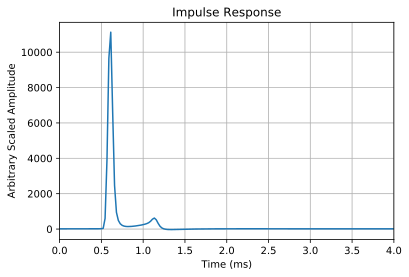

In [17]:
HRIR = freqr2imp(HRTF,win_att=100)
# Scale HRIR so the area is unity
G0 = 1/(sum(HRIR)*1/fs)
t = arange(len(HRIR))/fs*1000
plot(t,roll(HRIR*G0,20)) # adjust the time delay, arbitrarily, to insure the response is causal
xlim([0,4])
title(r'Impulse Response')
ylabel(r'Arbitrary Scaled Amplitude')
xlabel(r'Time (ms)')
grid();

In [14]:
def compute_HRIR(theta_deg, r = 1.0, R = 0.0875, 
                 fs = 44100, roll_factor = 20):
    """
    HRIR for rigid sphere
    
    theta_deg = angle between source and ear canal
    r = source to sphere center (m)
    R = shpere radius (m)
    fs = sampling rate in Hz
    roll_factor = adjust fixed time delay
    
    t = time axis in ms for plotting
    HRIR = scaled HRIR
    
    
    Mark Wickert, June 2019
    """
    Nfft = 2**10
    df = fs/Nfft
    f = np.arange(df,fs/2,df)
    df = fs/Nfft
    f = np.arange(df,fs/2,df)
    HRTF = np.zeros(len(f),dtype=complex128)
    for k, fk in enumerate(f):
        HRTF[k] = HRTF_sph(theta_deg,fk,r=r,R = R)
    # Set DC value to 1
    HRTF = np.hstack(([1],HRTF))
    f = np.hstack(([0],f))
    
    HRIR = freqr2imp(HRTF,win_att=100)
    # Scale HRIR so the area is unity
    G0 = 1/(np.sum(HRIR)*1/fs)
    t = np.arange(len(HRIR))/fs*1000
    return t, np.roll(G0*HRIR,roll_factor)

### Create X, Y, Z matrices for 3D Wireframe Plots

In [15]:
HRIR_mat = zeros((19,200))
for k in range(19):
    t, HRIR = compute_HRIR(10*k)
    HRIR_mat[k,:] = HRIR[:200]
t_mat, theta_mat = meshgrid(t[:200],arange(0,190,10))

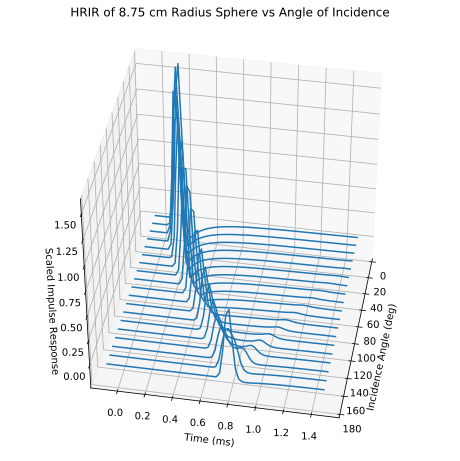

In [16]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the test data
# X, Y, Z = axes3d.get_test_data(0.05)

# Give the first plot only wireframes of the type y = c
ax.plot_wireframe(theta_mat[:,:70], t_mat[:,:70]-.08, HRIR_mat[:,:70]/2e4, rstride=1, cstride=0)
# ax.set_title("Column (x) stride set to 0");

# xlim([0,1.5])
# title(r'Impulse Response')
xlim([0,180])
ax.set_xlabel(r'Incidence Angle (deg)')
ax.set_ylabel(r'Time (ms)')
ax.set_zlabel(r'Scaled Impulse Response')
ax.set_title(r'HRIR of 8.75 cm Radius Sphere vs Angle of Incidence',pad=38);

ax.view_init(elev=40, azim=10) # 40 10
# Turn off the axis planes
# ax.set_axis_off()
#savefig('HRIR_875_sphere_vs_angle2.pdf',transparent=True)

## CIPIC Grid
Draw a plot of the CIPIC 1250 point sound source angle-of-arrival grid. An graphics program enhanced version of the plot is shown below this cell.

In [ ]:
fig = figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
radius = 1.0
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
rot = 80.0 / 180 * np.pi
ax.plot_surface(x, y, z, rstride=4, cstride=4, color='b',
                linewidth=0, alpha=0.2)

ax.plot(radius * np.sin(u), radius * np.cos(u), 0, color='k',
            linestyle='dashed', alpha=0.5)
ax.plot(radius * np.sin(u), zeros(len(u)), radius * np.cos(u), color='k',
            linestyle='dashed', alpha=0.5)
ax.plot(zeros(len(u)),radius * np.sin(u), radius * np.cos(u), color='k',
            linestyle='dashed', alpha=0.5)

# Plot CIPIC source locations
radius2 = 1.0
AZ_deg = array([-80., -65., -55., -45., -40., -35., -30., -25., -20., -15., -10.,
                -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,
                55.,  65.,  80.])
EL_deg = array([-45.   , -39.375, -33.75 , -28.125, -22.5  , -16.875, -11.25 ,
                -5.625,   0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,
                33.75 ,  39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,
                73.125,  78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875,
                112.5  , 118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 ,
                151.875, 157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625,
                191.25 , 196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   ,
                230.625])

for m in range(12,25): # CIPIC elevation
    for n in range(50): # CIPIC elevation
        ax.scatter([radius2 * sin(pi/180*AZ_deg[m])], 
                   [radius2 * cos(pi/180*AZ_deg[m])*cos(pi/180*EL_deg[n])],
                   [radius2 * cos(pi/180*AZ_deg[m])*sin(pi/180*EL_deg[n])], 
                   s=1, color='r', alpha=1.0)

ax.set_xlabel(r'$x_1$ ECEF (m)')
ax.set_ylabel(r'$x_2$ ECEF (m)')
ax.set_zlabel(r'$x_3$ ECEF (m)')
ax.set_title(r'CIPIC Source Locations on 1m Sphere (right side only)',pad=-50);
ax.view_init(elev=10, azim=30)
# Turn off the axis planes
ax.set_axis_off()
#savefig('source_locations2.pdf',transparent=True)

<img src="figures/CIPIC_Source_Locations.png" width="70%">
<!--- Image('figures/CIPIC_Source_Locations.png',width='90%')--->

## Writing a CIPIC HRIR Data Set for a Spherical Head Model
Finally we develope code to write a CIPIC-like HRIR data set. We follow the CIPIC ZIP file format of using a subject folder to hold a `.mat` file containing a 3D array of dimensions `(25, 50, 200)`.

In [20]:
# Write a CIPIC-like HRIR database entry
hrir_r = zeros((25,50,200))
hrir_l = zeros((25,50,200))
phi_R = 80
phi_L = 280
r = 1.0  # sound source distance from head center
R = 0.0875 # spherical head radius
fs = 44100
for n, theta_AZn in enumerate(AZ_deg):
    for m, phi_ELm in enumerate(EL_deg):
        theta_SR = arccos(sin(phi_R*pi/180) \
                         *sin(theta_AZn*pi/180)
                         -cos(phi_R*pi/180) \
                         *cos(phi_ELm*pi/180) \
                         *cos(theta_AZn*pi/180))
        theta_SL = arccos(sin(phi_L*pi/180) \
                         *sin(theta_AZn*pi/180)
                         -cos(phi_L*pi/180) \
                         *cos(phi_ELm*pi/180) \
                         *cos(theta_AZn*pi/180))
        t, HRIR_R = compute_HRIR(theta_SR*180/pi,r,R,fs)
        hrir_r[n,m,:] = HRIR_R[:200]
        t, HRIR_L = compute_HRIR(theta_SL*180/pi,r,R,fs)
        hrir_l[n,m,:] = HRIR_L[:200]
#io.savemat('test_save',{'hrir_l':hrir_l,'hrir_r':hrir_r})

* Make a directory for storing the `.mat` file using a subject number such as 200 and above to avoid conflict with the CIPIC subject numbers

mkdir subject_200

* The CIPIC convention dictates the `.mat` be named `hrir_final`
* An arbitrary scale factor of 2e4 is used to approximately match the audio gain level of the typical CIPIC file

In [49]:
io.savemat('subject_200/hrir_final',{'hrir_l':hrir_l/2e4,'hrir_r':hrir_r/2e4})

* Subject_200 is a sphere with $R = 8.75$ cm
* Subject_201 is a sphere with $R = 10$ cm
* Validate the contents of `subject_200`

In [50]:
io.whosmat('subject_200/hrir_final.mat')

[('hrir_l', (25, 50, 200), 'double'), ('hrir_r', (25, 50, 200), 'double')]

* A regular CIPIC `.mat` file contains additional matrices as shown below for, subject_165`:

In [51]:
io.whosmat('subject_165/hrir_final.mat')

[('OnR', (25, 50), 'double'),
 ('OnL', (25, 50), 'double'),
 ('ITD', (25, 50), 'double'),
 ('hrir_r', (25, 50, 200), 'double'),
 ('hrir_l', (25, 50, 200), 'double'),
 ('name', (1,), 'char')]

In [3]:
class ss_mapping2CIPIChrir(object):
    """
    A class for sound source mapping to the CIPIC HRIR database
    
    CIPIC uses the interaural polar coordinate system (IPCS).
    The reference sphere for the head-related transfer function 
    (HRTF) measurements/head-related impulse response (HRIR) 
    measurements has a 1m radius.
    
    
    Mark Wickert June 2018
    """
    def __init__(self,sub_foldername,head_radius_cm = 8):
        """
        Object instantiation
        
        The default head radius is 8cm or 0.08m
        """
        # Store the head radius in meters
        self.head_radius = head_radius_cm/100
        
        # Store the HRIR 200 tap FIR filter coefficient sets
        self.subject = sub_foldername
        hrir_LR = io.loadmat( self.subject + '/hrir_final.mat')
        self.hrirL = hrir_LR['hrir_l']
        self.hrirR = hrir_LR['hrir_r']
        
        # Create LUTs for the azimuth and elevation values.
        # This will make it easy to quantize a given source location
        # to one of the available HRIRs in the database.
        self.Az_LUT = hstack(([-80,-65,-55],arange(-45,45+5,5.0),[55,65,80]))
        self.El_LUT = -45 + 5.625*arange(0,50)
        
        # Initialize parameters
        self.tR = 1 # place source on unit sphere
        self.tL = 1 # directly in front of listener
        self.elRL = 0
        self.azR = 0
        self.azL = 0
        self.AzR_idx = 0
        self.AzL_idx = 0
        self.ElRL_idx = 0
        
        # Store corresponding right and left ear FIR filter coefficients
        self.coeffR = self.hrirR[0,0,:]
        self.coeffL = self.hrirL[0,0,:]
        
        
    
    def cart2ipcs(self,x1,y1,z1):
        """
        Map cartesian source coordinates (x1,y1,z1) to the 
        CIPIC interaural polar coordinate system (IPCS) 
        for easy access to CIPIC HRIR. Parallax error is 
        also dealt with so two azimuth values are found. 
        To fit IPCS the cartesian coordinates are defined 
        as follows:

        (0,0,0) <--> center of head.
        (1,0,0) <--> unit vector pointing outward from the right 
                     on a line passing from left to right through
                     the left and right ear (pinna) ear canals
        (0,1,0) <--> unit vector pointint out through the top 
                     of the head.
        (0,0,1) <--> unit vector straight out through the back of 
                     the head, such that a right-handed coordinate
                     system is formed.

        Mark Wickert June 2018
        """
        # First solve for the parameter t, which is used to describe 
        # parametrically the location of the source at (x1,y1,z1) on a line 
        # connecting the right or left ear canal entry point to the 
        # unit sphere.

        # The right ear (pinna) solution
        aR = (x1-self.head_radius)**2 + y1**2 + z1**2
        bR = 2*self.head_radius*(x1-self.head_radius)
        cRL = self.head_radius**2 - 1
        # The left ear (pinna) solution
        aL = (x1+self.head_radius)**2 + y1**2 + z1**2
        bL = -2*self.head_radius*(x1+self.head_radius)

        # Find the t values which are also the gain values 
        # to be applied to the filter.
        self.tR = max((-bR+sqrt(bR**2-4*aR*cRL))/(2*aR),
                 (-bR-sqrt(bR**2-4*aR*cRL))/(2*aR))
        self.tL = max((-bL+sqrt(bL**2-4*aL*cRL))/(2*aL),
                 (-bL-sqrt(bL**2-4*aL*cRL))/(2*aL))
        #print('tR = %6.2e, tL = %6.2e' % (self.tR,self.tL))
        elRL = 180/pi*arctan2(y1,-z1)
        if elRL < -90:
            elRL += 360
        self.elRL = elRL
        self.azR = 180/pi*arcsin(clip(self.head_radius \
                                 + self.tR*(x1-self.head_radius),-1,1))
        self.azL = 180/pi*arcsin(clip(-self.head_radius \
                                 + self.tL*(x1+self.head_radius),-1,1))
        #print('elRL = %4.2f, azR = %4.2f, azL = %4.2f' \
        #      % (self.elRL,self.azR,self.azL))
        
        self.AzR_idx = argmin((self.Az_LUT - self.azR)**2)
        self.AzL_idx = argmin((self.Az_LUT - self.azL)**2)
        self.ElRL_idx = argmin((self.El_LUT - self.elRL)**2)
        self.coeffR = self.hrirR[self.AzR_idx,self.ElRL_idx,:]
        self.coeffL = self.hrirL[self.AzL_idx,self.ElRL_idx,:]

### Overlay Plot of the Right and Left Ear Impulse Responses versus Source Location
The cell below shows the scaled HRIR for the right and left channels as a function of the source location in cyclindrical coordinates. Jupyter widgets are uses to provide an interactive experience.

* Subject 200 corresponds to a spherical head with mean radius of 8.75 cm and the ear canal set back of $\pm 100^\circ$ from the front of the spherical head

In [4]:
subject = ss_mapping2CIPIChrir('subject_200') # 'subject_165'
@interact(p_theta = widgets.IntSlider(min=0,max=360,step=5,value=90),
          p_r = widgets.FloatSlider(min=0.1,max=4,step=0.1,value=1),
          p_y = widgets.FloatSlider(min=-5,max=5,step=0.1,value=0.0))
def f(p_theta,p_r,p_y):
    subject.cart2ipcs(p_r*sin(pi/180*p_theta),
                      p_y,
                      p_r*cos(pi/180*p_theta))
    
    t = arange(0,200)/44.100
    plot(subject.tR*subject.coeffR)
    plot(subject.tL*subject.coeffL)
    title(r'Head-Related Impulse Response versus Source Location')
    ylabel(r'Amplitude')
    xlabel(r'Time (ms)')
    legend((r'Right',r'Left'))
    ylim([-1.0,1.75])
    grid();

interactive(children=(IntSlider(value=90, description='p_theta', max=360, step=5), FloatSlider(value=1.0, desc…